In [1]:
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import os
from pathlib import Path

In [2]:
def evaluation_network(filename):
    with open(filename, "r") as file:
        iter, quality, time = [], [], []
        max_quality = 0
        for line in csv.reader(file):
            if len(line) > 1:
                q = 1 / float(line[1])
                max_quality = max(max_quality, q)
                quality.append(q)
                iter.append(int(line[0]))
                time.append(int(line[2]))
        
        print(quality)
        print(f"Max Quality: {max_quality}, 90%: {max_quality*.9}")
        quasi_optimal = [d for d in quality if d / max_quality >= .9][0]
        # quasi_optimal = min([d for d in quality], key=lambda d: abs(d - (max_quality*.9)))
        quick_dirty = min([d for d in quality], key=lambda d: abs(d - (max_quality*.5)))
        print(f"Quasi-optimal stage: {quasi_optimal}")
        print(f"Quick and dirty: {quick_dirty}")

        data = pd.DataFrame(list(zip(iter, quality)), columns=['time', 'quality'])
        title = filename.removesuffix(".gexf.csv")
        plot = sns.lineplot(data, x='time', y='quality', color="black")
        
        plot.set(xticklabels=[])  
        plot.set(yticklabels=[])  
        plot.set(title=title)
        plot.set(xlabel="Time")
        plot.set(ylabel="Quality")
        plot.tick_params(bottom=False)  # remove the ticks
        plot.tick_params(left=None)  # remove the ticks
        plot.scatter([iter[quality.index(quick_dirty)]], [quality[quality.index(quick_dirty)]], color="red")
        plot.scatter([iter[quality.index(quasi_optimal)]], [quality[quality.index(quasi_optimal)]], color="blue")
        plt.show()

In [11]:
def overall_benchmark_evaluation(dir, save_path="results_imgs"):
    algo_patterns = ['FA2_LL_random', 'FA2_random', 'OO_random', 'YH_random', 'YH_P_random']
    algos_max_quality = []
    algos_quick_dirty = []
    algos_quasi_optimal = []

    for pattern in algo_patterns:
        print(pattern)
        max_qualities, quick_dirties, quasi_optimalities = [], [], []

        for filepath in glob.glob(dir + f"/{pattern}*.gexf.csv"):
            with open(filepath) as file:
                iter, quality, time = [], [], []
                max_quality = 0
                for line in csv.reader(file):
                    if len(line) > 1:
                        if line[1] == "NaN" or float(line[1]) == 0.0: continue
                        q = 1 / float(line[1])
                        max_quality = max(max_quality, q)
                        quality.append(q)
                        iter.append(int(line[0]))
                        time.append(int(line[2]))
                
                # print(f"Max Quality: {max_quality}, 90%: {max_quality*.9}")
                quasi_optimal = [d for d in quality if d/max_quality >= .9][0]
                if quality.index(quasi_optimal) in [len(quality)-2, len(quality)-1]:
                    quasi_optimal = min([d for d in quality], key=lambda d: abs(d - (max_quality*.9)))
                quick_dirty = min([d for d in quality], key=lambda d: abs(d - (max_quality*.5)))
                # print(f"Quasi-optimal stage: {quasi_optimal}")
                # print(f"Quick and dirty: {quick_dirty}")

                max_qualities.append(max_quality)
                quasi_optimalities.append(time[quality.index(quasi_optimal)] - time[0])
                quick_dirties.append(time[quality.index(quick_dirty)] - time[0])

                data = pd.DataFrame(list(zip(iter, quality)), columns=['time', 'quality'])
                title = os.path.basename(filepath).removesuffix(".gexf.csv")
                plot = sns.lineplot(data, x='time', y='quality', color="black")
                
                plot.set(xticklabels=[])  
                plot.set(yticklabels=[])  
                plot.set(title=title)
                plot.set(xlabel="Time")
                plot.set(ylabel="Quality")
                plot.tick_params(bottom=False)  # remove the ticks
                plot.tick_params(left=None)  # remove the ticks
                plot.scatter([iter[quality.index(quick_dirty)]], [quality[quality.index(quick_dirty)]], color="red")
                plot.scatter([iter[quality.index(quasi_optimal)]], [quality[quality.index(quasi_optimal)]], color="blue")
                plt.savefig(f"{save_path}/{title}.png")
                plt.close()
        
        if len(max_qualities) > 0:
            algos_max_quality.append(sum(max_qualities) / len(max_qualities))
            algos_quick_dirty.append(sum(quick_dirties) / len(quick_dirties))
            algos_quasi_optimal.append(sum(quasi_optimalities) / len(quasi_optimalities))
    
    if algos_max_quality != []:
        print("->", algos_max_quality, algos_quick_dirty, algos_quasi_optimal)
        data = pd.DataFrame(list(zip([n.removesuffix("_random") for n in algo_patterns], algos_max_quality, algos_quick_dirty, algos_quasi_optimal)), columns=['names', 'avg_max_quality', 'avg_quick_dirty', 'avg_quasi_optimal'])
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Benchmark Overall Results")
        axes[0,0].grid(zorder=0)
        bar_plt_1 = sns.barplot(data, ax=axes[0,0], x='names', y='avg_max_quality', zorder=3)
        bar_plt_1.set(yscale="log")
        # bar_plt_1.set(xticklabels=[])
        bar_plt_1.tick_params(bottom=False)  # remove the ticks
        bar_plt_1.set(xlabel="Average Max Quality (higher is better)")
        # plt.show()
        axes[0,1].grid(zorder=0)
        bar_plt_2 = sns.barplot(data, ax=axes[0,1], x='names', y='avg_quick_dirty', zorder=3)
        # bar_plt_2.set(yscale="log")
        # bar_plt_2.set(xticklabels=[])
        bar_plt_2.tick_params(bottom=False)  # remove the ticks
        bar_plt_2.set(xlabel="Average Quick and Dirty Time (ms) (lower is better)")
        # plt.show()
        axes[1,0].grid(zorder=0)
        bar_plt_3 = sns.barplot(data, ax=axes[1,0], x='names', y='avg_quasi_optimal', zorder=3)
        # bar_plt_3.set(yscale="log")
        # bar_plt_3.set(xticklabels=[])
        bar_plt_3.tick_params(bottom=False)  # remove the ticks
        bar_plt_3.set(xlabel="Average Quasi-Optimal Time (ms) (lower is better)")
        # plt.show()
        table = plt.table(cellText=data[['avg_max_quality', 'avg_quick_dirty', 'avg_quasi_optimal']].values.transpose(),
              colLabels=data['names'].values,
              rowLabels=['avg_max_quality', 'avg_quick_dirty', 'avg_quasi_optimal'],
            #   colLabels=data.columns,
            #   rowLabels=data.index,
              cellLoc = 'center', rowLoc = 'center',
              bbox = ([0.176, 0, 1-0.176, 1]))
        table.auto_set_font_size(False)
        table.set_fontsize(6)
        plt.savefig(f"{save_path}/overall_benchmark.png")

FA2_LL_random
FA2_random
OO_random
YH_random
YH_P_random
-> [2.152514208244898, 2.63143719329706, 40746.059132566166, 1.7569287058815006, 1.7569287058815006] [195042.66666666666, 111162.68279569893, 184478.9301075269, 118572.81182795699, 123990.33333333333] [327770.688172043, 244964.6182795699, 161656.6075268817, 182830.70430107528, 194385.5483870968]


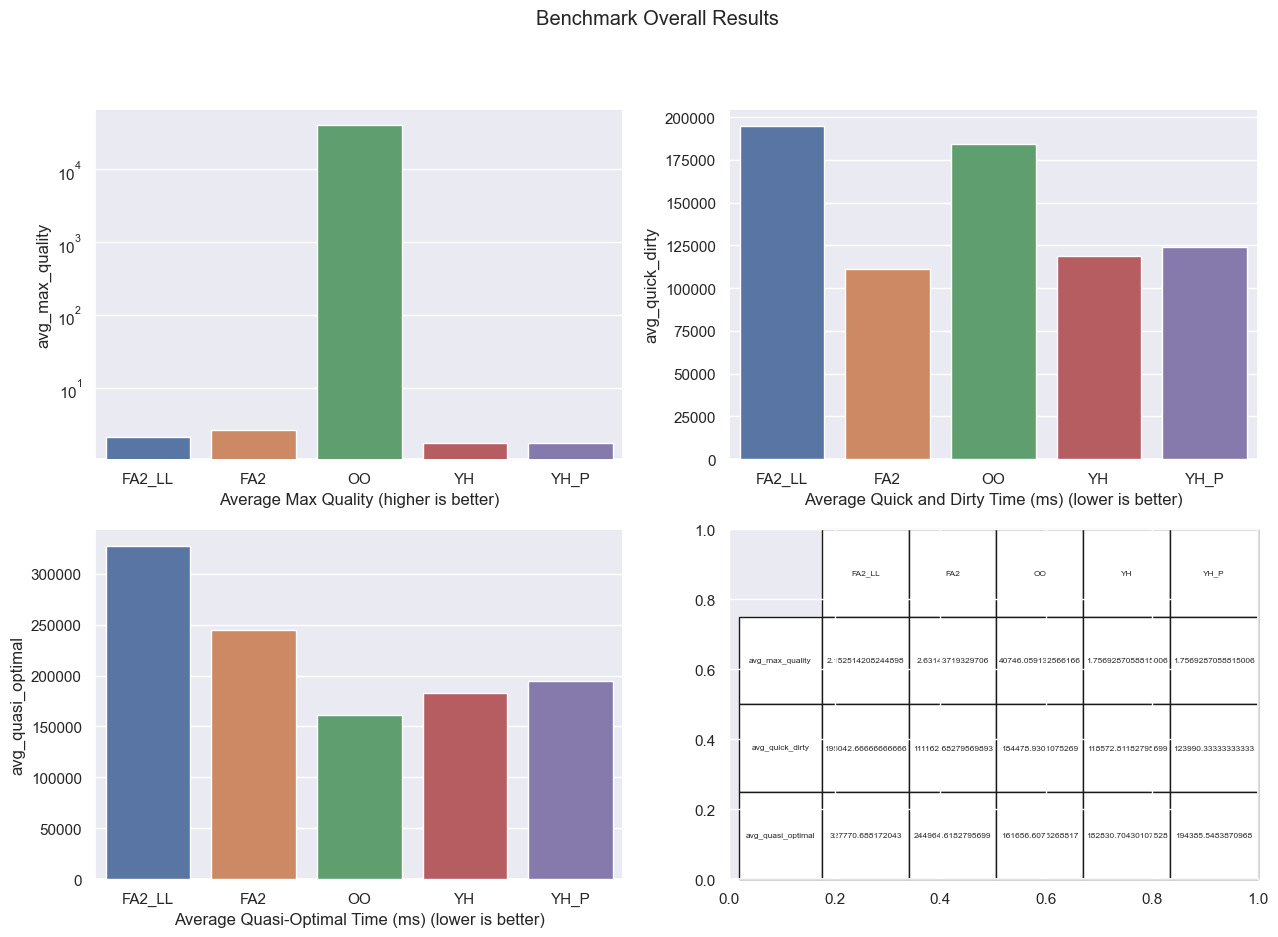

In [12]:
overall_benchmark_evaluation("./benchmarked/")

In [13]:
def quasi_optimal_time_over_networks(dir, save_path="results_imgs"):
    networks = {'facebook_ego_0.edges': [333, 5038, 30.25825825825826], 'facebook_ego_1.edges': [333, 5038, 30.25825825825826], 'facebook_ego_348.edges': [224, 6384, 57.0], 'facebook_ego_414.edges': [150, 3386, 45.14666666666667], 'facebook_ego_698.edges': [61, 540, 17.704918032786885], 'facebook_ego_107.edges': [1034, 53498, 103.47775628626692], 'facebook_ego_3437.edges': [534, 9626, 36.052434456928836], 'facebook_ego_3980.edges': [52, 292, 11.23076923076923], 'facebook_ego_1912.edges': [747, 60050, 160.7764390896921], 'facebook_ego_1684.edges': [786, 28048, 71.36895674300254], 'facebook_ego_686.edges': [168, 3312, 39.42857142857143], 'twitter_21420959.edges': [91, 1787, 39.27472527472528], 'twitter_24117694.edges': [246, 9630, 78.29268292682927], 'twitter_15053535.edges': [18, 26, 2.888888888888889], 'twitter_215328630.edges': [10, 33, 6.6], 'twitter_248883350.edges': [184, 9042, 98.28260869565217], 'twitter_15924858.edges': [10, 39, 7.8], 'twitter_430313102.edges': [51, 1646, 64.54901960784314], 'twitter_23503181.edges': [101, 1824, 36.118811881188115], 'twitter_163374693.edges': [164, 1749, 21.329268292682926], 'twitter_314316607.edges': [235, 15957, 135.80425531914895], 'twitter_256497288.edges': [213, 17930, 168.3568075117371], 'twitter_96545499.edges': [13, 38, 5.846153846153846], 'twitter_217796457.edges': [184, 12105, 131.57608695652175], 'twitter_22252971.edges': [23, 34, 2.9565217391304346], 'twitter_200214366.edges': [183, 9451, 103.2896174863388], 'twitter_22106463.edges': [156, 1815, 23.26923076923077], 'twitter_98801140.edges': [5, 5, 2.0], 'twitter_396721965.edges': [9, 21, 4.666666666666667], 'twitter_89826562.edges': [216, 9715, 89.95370370370371], 'twitter_9460682.edges': [88, 2003, 45.52272727272727], 'twitter_175553601.edges': [201, 8888, 88.43781094527363], 'twitter_40777046.edges': [25, 39, 3.12], 'twitter_14711172.edges': [6, 8, 2.6666666666666665], 'twitter_43858661.edges': [11, 37, 6.7272727272727275], 'twitter_26346966.edges': [78, 1928, 49.43589743589744], 'twitter_307458983.edges': [228, 9938, 87.17543859649123], 'twitter_19933035.edges': [62, 1632, 52.645161290322584], 'twitter_16987303.edges': [193, 13538, 140.2901554404145], 'twitter_18481292.edges': [77, 1732, 44.98701298701299], 'twitter_9254272.edges': [155, 1779, 22.954838709677418], 'oregon2_010331.txt': [10900, 31180, 5.721100917431193], 'oregon2_010407.txt': [10981, 30855, 5.619706766232584], 'oregon2_010428.txt': [11113, 31434, 5.657158283091874], 'oregon2_010505.txt': [11157, 30943, 5.546831585551671], 'oregon2_010512.txt': [11260, 31303, 5.560035523978685], 'oregon2_010519.txt': [11375, 32287, 5.676835164835165], 'oregon2_010526.txt': [11461, 32730, 5.711543495331996], 'oregon2_010414.txt': [11019, 31761, 5.764769942826028], 'oregon2_010421.txt': [11080, 31538, 5.692779783393502], 'ca-CondMat.txt': [23133, 93497, 8.083430596982666], 'ca-GrQc.txt': [5242, 14496, 5.530713468141931], 'ca-HepPh.txt': [12008, 118521, 19.740339773484344], 'YeastS.net': [2361, 7182, 6.083862770012707], 'celegans': [306, 2345, 7.663], 'mavel': [10469, 178115, 34.027]}
    new_networks = {'cit-HepPh.txt': [34546, 421578, 24.406761998494762], 'cit-HepTh.txt': [27770, 352807, 25.409218581202737], 'email-Enron.txt': [36692, 367662, 20.040444783604055], 'p2p-Gnutella24.txt': [26518, 65369, 4.930160645599216], 'p2p-Gnutella25.txt': [22687, 54705, 4.822585621721691], 'sx-mathoverflow.txt': [24818, 239978, 19.339028124748168], 'sx-mathoverflow-a2q.txt': [21688, 90489, 8.344614533382515], 'sx-mathoverflow-c2a.txt': [13840, 81121, 11.722687861271677], 'sx-mathoverflow-c2q.txt': [16836, 101329, 12.037182228557851], 'musae_facebook_edges.csv': [22470, 171002, 15.220471740097908]}
    networks = {**networks, **new_networks}

    values = {}

    for k in networks.keys():
        pattern = k
        if "." in k:
            pattern = k[:k.index(".")]
        quasi_optimals = []
        for filepath in glob.glob(dir + f"/*{pattern}*.gexf.csv"):
            with open(filepath) as file:
                iter, quality, time = [], [], []
                max_quality = 0
                for line in csv.reader(file):
                    if len(line) > 1:
                        if line[1] == "NaN" or float(line[1]) == 0.0: continue
                        q = 1 / float(line[1])
                        max_quality = max(max_quality, q)
                        quality.append(q)
                        iter.append(int(line[0]))
                        time.append(int(line[2]))
                
                # print(f"Max Quality: {max_quality}, 90%: {max_quality*.9}")
                quasi_optimal = [d for d in quality if d/max_quality >= .9][0]
                if quality.index(quasi_optimal) in [len(quality)-2, len(quality)-1]:
                    quasi_optimal = min([d for d in quality], key=lambda d: abs(d - (max_quality*.9)))
                
                quasi_optimals.append(quasi_optimal)
            algo = [n for n in ['FA2_LL_random', 'FA2_random', 'OO_random', 'YH_random', 'YH_P_random'] if n in os.path.basename(filepath)][0]
            values[algo.removesuffix("random") + k[:k.index(".")]] = [k, algo.removesuffix("_random"), sum(quasi_optimals) / len(quasi_optimals), networks[k][0]]

    data = pd.DataFrame(values).transpose()
    data.rename(columns={0: 'network', 1: 'algo', 2: 'quasi_optimal', 3: 'nodes'}, inplace=True)

    sns.set(rc={'figure.figsize':(15, 10)})
    plot = sns.scatterplot(data=data, x='nodes', y='quasi_optimal', hue='algo')
    plot.set_title("Quasi-Optimal Time over network size")
    plot.set(yscale="log")
    plot.set(xscale="log")
    plot.set(xlabel="size of the network")
    plot.set(ylabel="Quasi-Optimal Time")
    plt.savefig(f"{save_path}/quasi_over_sizes.png")
    # return values

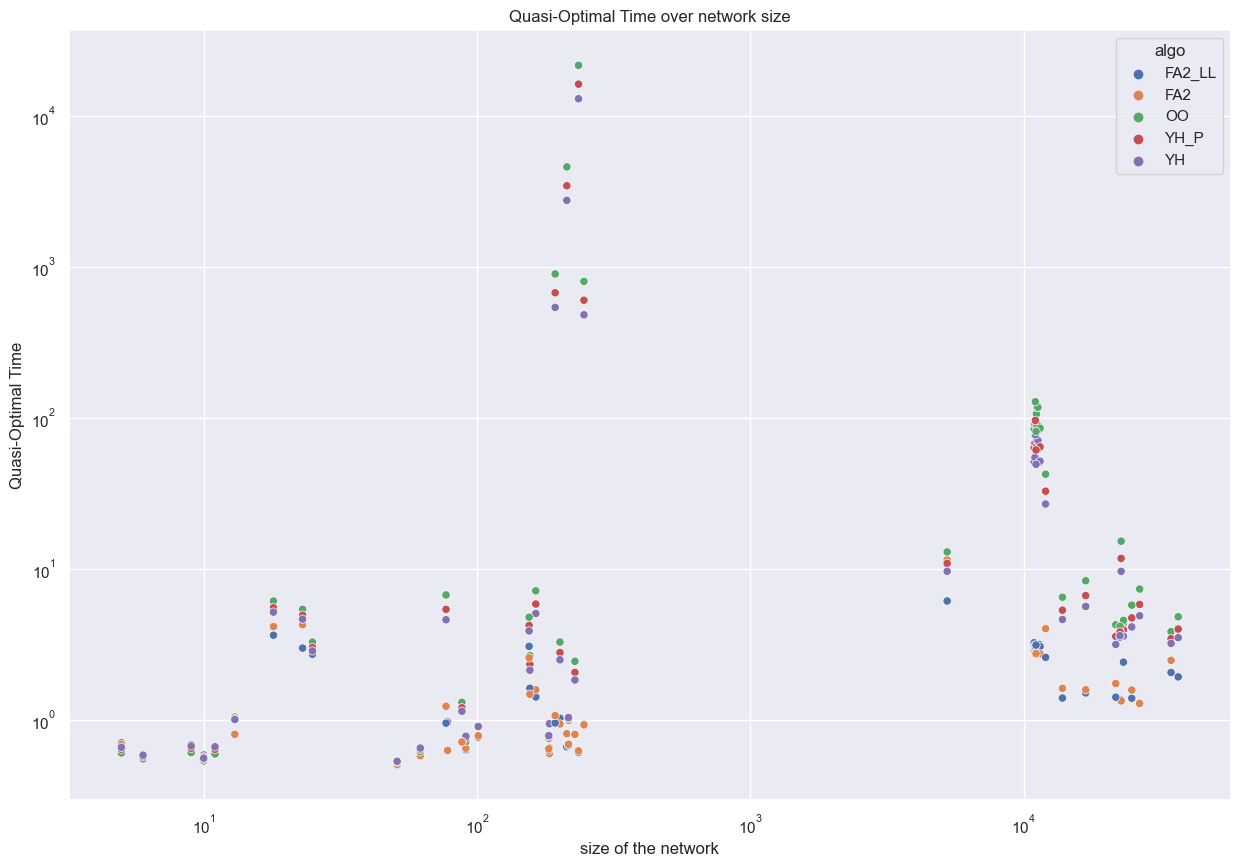

In [14]:
quasi_optimal_time_over_networks("./benchmarked")